In [37]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

In [39]:
import pandas as pd
import numpy as np

In [40]:
def read_data(init):
    """
    Reads and concatenates parquet files containing forecast and error data for GFS, NAM, and HRRR weather models
    for the years 2018 to 2021, with random forecasts that have a forecast hour of 0 removed.

    Args:
        init (str): A string representing the initial time of the forecast (in UTC).

    Returns:
        tuple of pandas.DataFrame: A tuple containing three dataframes, one for each weather model, with random
        forecasts that have a forecast hour of 0 removed.
    """
    years = ["2018", "2019", "2020", "2021"]
    savedir = "/home/aevans/ai2es/processed_data/frcst_err/"

    # create empty lists to hold dataframes for each model
    nam_fcast_and_error = []
    gfs_fcast_and_error = []
    hrrr_fcast_and_error = []

    # loop over years and read in parquet files for each model
    for year in years:
        nam_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}nam_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        gfs_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}gfs_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        hrrr_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}hrrr_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )

    # concatenate dataframes for each model
    nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
    gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)

    # remove random forecasts that have forecast hours 0 for each model
    gfs_fcast_and_error_df = gfs_fcast_and_error_df[
        gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    nam_fcast_and_error_df = nam_fcast_and_error_df[
        nam_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df[
        hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]

    # return dataframes for each model
    return gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df

In [41]:
def col_drop(df):
    df = df.drop(
        columns=[
            "station",
            "time",
            "t2m_error",
            "d2m_error",
            "u_total_error",
            "u_dir_error",
            "new_tp_error",
            "mslma_error",
            "lead_time_DAY",
            "lead_time_HOUR",
            "lead_time_ONLY_HOURS",
        ]
    )
    return df

In [42]:
gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df = read_data(
    "12"
)

In [43]:
hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index()
df1 = hrrr_fcast_and_error_df[hrrr_fcast_and_error_df["station"] == "SCHU"]
df1 = col_drop(df1)

In [44]:
hrrr_fcast_and_error_df.keys()

Index(['station', 'valid_time', 'time', 't2m_HRRR', 'd2m_HRRR', 'u_total_HRRR',
       'u_dir_HRRR', 'latitude', 'longitude', 'new_tp_HRRR', 'mslma_HRRR',
       'orog', 't2m_error', 'd2m_error', 'u_total_error', 'u_dir_error',
       'new_tp_error', 'mslma_error', 't2m_nysm', 'd2m_nysm', 'u_total_nysm',
       'u_dir_nysm', 'new_tp_nysm', 'mslma_nysm', 'lead_time_DAY',
       'lead_time_HOUR', 'lead_time_ONLY_HOURS'],
      dtype='object')

In [45]:
df1.head()

,valid_time,t2m_HRRR,d2m_HRRR,u_total_HRRR,u_dir_HRRR,latitude,longitude,new_tp_HRRR,mslma_HRRR,orog,t2m_nysm,d2m_nysm,u_total_nysm,u_dir_nysm,new_tp_nysm,mslma_nysm
46874,2018-01-01 14:00:00,-26.027145,-28.905670,0.644868,187.528809,43.110052,-73.591823,0.0,1028.459961,40.151505,-25.742041,-28.596741,1.591372,210.035599,0.0,1025.776978
46875,2018-01-01 15:00:00,-21.798660,-25.074158,1.103367,155.350861,43.110052,-73.591823,0.0,1029.729980,40.151505,-21.868660,-26.147049,1.213672,157.646805,0.0,1025.878052
46876,2018-01-01 16:00:00,-19.001190,-22.717117,0.666412,145.490784,43.110052,-73.591823,0.0,1029.319946,40.151505,-19.732401,-26.048782,1.831618,164.235596,0.0,1025.290039
46877,2018-01-01 17:00:00,-17.341324,-21.778854,0.146325,117.390900,43.110052,-73.591823,0.0,1028.380005,40.151505,-17.451130,-25.813904,1.986071,153.697601,0.0,1024.595947
46878,2018-01-01 18:00:00,-16.004486,-21.128281,0.255038,85.514633,43.110052,-73.591823,0.0,1028.109985,40.151505,-15.916540,-24.726959,1.331371,132.341202,0.0,1023.705017


In [46]:
df2 = hrrr_fcast_and_error_df[hrrr_fcast_and_error_df["station"] == "SCHA"]
df2 = col_drop(df2)

In [47]:
df2.head()

,valid_time,t2m_HRRR,d2m_HRRR,u_total_HRRR,u_dir_HRRR,latitude,longitude,new_tp_HRRR,mslma_HRRR,orog,t2m_nysm,d2m_nysm,u_total_nysm,u_dir_nysm,new_tp_nysm,mslma_nysm
45795,2018-01-01 13:00:00,-23.531738,-28.160782,2.058989,171.927307,42.895208,-73.631782,0.0,1029.250000,80.089005,-27.436831,-30.272278,0.867536,153.156799,0.0,1016.046021
45796,2018-01-01 14:00:00,-22.652145,-26.218170,1.262130,286.605469,42.895208,-73.631782,0.0,1028.550049,80.089005,-24.962179,-27.859283,1.144150,97.715698,0.0,1016.408997
45797,2018-01-01 15:00:00,-20.736160,-24.449158,1.127025,292.686096,42.895208,-73.631782,0.0,1029.800049,80.089005,-20.868441,-26.142456,0.660567,254.025604,0.0,1016.729004
45798,2018-01-01 16:00:00,-18.313690,-22.154617,0.936298,312.983215,42.895208,-73.631782,0.0,1029.300049,80.089005,-18.719721,-26.159714,0.433161,252.902206,0.0,1016.018982
45799,2018-01-01 17:00:00,-16.341339,-20.091354,0.981451,325.380920,42.895208,-73.631782,0.0,1028.369995,80.089005,-16.956671,-25.267960,1.897589,271.189209,0.0,1015.424011


In [48]:
df3 = hrrr_fcast_and_error_df[hrrr_fcast_and_error_df["station"] == "BSPA"]
df3 = col_drop(df3)

In [49]:
df3.head()

,valid_time,t2m_HRRR,d2m_HRRR,u_total_HRRR,u_dir_HRRR,latitude,longitude,new_tp_HRRR,mslma_HRRR,orog,t2m_nysm,d2m_nysm,u_total_nysm,u_dir_nysm,new_tp_nysm,mslma_nysm
7752,2018-01-01 13:00:00,-25.156738,-28.723282,2.446105,252.732498,43.028108,-73.887944,0.0,1029.339966,123.089005,-23.723141,-27.914566,0.785957,284.252106,0.0,1012.898987
7753,2018-01-01 14:00:00,-22.402145,-26.593170,2.283543,255.368942,43.028108,-73.887944,0.0,1028.579956,123.089005,-22.250919,-27.442368,2.854406,241.898193,0.0,1013.429993
7754,2018-01-01 15:00:00,-18.923660,-24.261658,2.391625,253.223251,43.028108,-73.887944,0.0,1029.739990,123.089005,-19.860109,-26.330994,2.980609,241.031998,0.0,1013.505005
7755,2018-01-01 16:00:00,-16.063690,-22.279617,1.601324,256.947571,43.028108,-73.887944,0.0,1029.359985,123.089005,-18.014620,-25.542313,4.187699,247.167999,0.0,1012.857971
7756,2018-01-01 17:00:00,-14.653839,-21.028854,0.696693,27.104160,43.028108,-73.887944,0.0,1028.369995,123.089005,-16.514090,-24.623291,3.436568,243.065002,0.0,1012.085999


In [50]:
df4 = hrrr_fcast_and_error_df[hrrr_fcast_and_error_df["station"] == "GFAL"]
df4 = col_drop(df4)

In [51]:
df4.head()

,valid_time,t2m_HRRR,d2m_HRRR,u_total_HRRR,u_dir_HRRR,latitude,longitude,new_tp_HRRR,mslma_HRRR,orog,t2m_nysm,d2m_nysm,u_total_nysm,u_dir_nysm,new_tp_nysm,mslma_nysm
24522,2018-01-01 13:00:00,-29.031738,-34.785782,1.107541,208.199310,43.331728,-73.587318,0.0,1028.979980,80.339005,-27.982321,-30.449158,0.996736,256.987488,0.0,1015.705017
24523,2018-01-01 14:00:00,-28.214645,-32.968170,0.945911,209.062820,43.331728,-73.587318,0.0,1028.219971,80.339005,-24.428221,-28.220245,0.899862,42.398178,0.0,1015.979004
24524,2018-01-01 15:00:00,-26.298660,-29.136658,0.477595,105.524284,43.331728,-73.587318,0.0,1029.459961,80.339005,-20.963320,-25.582031,2.063770,165.777802,0.0,1016.275024
24525,2018-01-01 16:00:00,-23.501190,-26.717117,0.303513,141.232452,43.331728,-73.587318,0.0,1029.180054,80.339005,-19.377131,-24.915131,3.083942,172.908997,0.0,1015.601990
24526,2018-01-01 17:00:00,-20.903824,-24.216354,0.322618,79.700516,43.331728,-73.587318,0.0,1028.260010,80.339005,-17.895691,-24.935181,2.468653,173.007202,0.0,1014.947998


In [52]:
the_df = df1.merge(df2, on="valid_time", suffixes=("_1", "_2"))
the_df = the_df.merge(df3, on="valid_time", suffixes=(None, "_3"))
the_df = the_df.merge(df4, on="valid_time", suffixes=(None, "_4"))

In [53]:
the_df.head()

,valid_time,t2m_HRRR_1,d2m_HRRR_1,u_total_HRRR_1,u_dir_HRRR_1,latitude_1,longitude_1,new_tp_HRRR_1,mslma_HRRR_1,orog_1,...,longitude_4,new_tp_HRRR_4,mslma_HRRR_4,orog_4,t2m_nysm_4,d2m_nysm_4,u_total_nysm_4,u_dir_nysm_4,new_tp_nysm_4,mslma_nysm_4
0,2018-01-01 14:00:00,-26.027145,-28.905670,0.644868,187.528809,43.110052,-73.591823,0.0,1028.459961,40.151505,...,-73.587318,0.0,1028.219971,80.339005,-24.428221,-28.220245,0.899862,42.398178,0.0,1015.979004
1,2018-01-01 15:00:00,-21.798660,-25.074158,1.103367,155.350861,43.110052,-73.591823,0.0,1029.729980,40.151505,...,-73.587318,0.0,1029.459961,80.339005,-20.963320,-25.582031,2.063770,165.777802,0.0,1016.275024
2,2018-01-01 16:00:00,-19.001190,-22.717117,0.666412,145.490784,43.110052,-73.591823,0.0,1029.319946,40.151505,...,-73.587318,0.0,1029.180054,80.339005,-19.377131,-24.915131,3.083942,172.908997,0.0,1015.601990
3,2018-01-01 17:00:00,-17.341324,-21.778854,0.146325,117.390900,43.110052,-73.591823,0.0,1028.380005,40.151505,...,-73.587318,0.0,1028.260010,80.339005,-17.895691,-24.935181,2.468653,173.007202,0.0,1014.947998
4,2018-01-01 18:00:00,-16.004486,-21.128281,0.255038,85.514633,43.110052,-73.591823,0.0,1028.109985,40.151505,...,-73.587318,0.0,1028.010010,80.339005,-16.601601,-24.450745,1.608683,187.223495,0.0,1014.231995


In [54]:
the_df.keys()

Index(['valid_time', 't2m_HRRR_1', 'd2m_HRRR_1', 'u_total_HRRR_1',
       'u_dir_HRRR_1', 'latitude_1', 'longitude_1', 'new_tp_HRRR_1',
       'mslma_HRRR_1', 'orog_1', 't2m_nysm_1', 'd2m_nysm_1', 'u_total_nysm_1',
       'u_dir_nysm_1', 'new_tp_nysm_1', 'mslma_nysm_1', 't2m_HRRR_2',
       'd2m_HRRR_2', 'u_total_HRRR_2', 'u_dir_HRRR_2', 'latitude_2',
       'longitude_2', 'new_tp_HRRR_2', 'mslma_HRRR_2', 'orog_2', 't2m_nysm_2',
       'd2m_nysm_2', 'u_total_nysm_2', 'u_dir_nysm_2', 'new_tp_nysm_2',
       'mslma_nysm_2', 't2m_HRRR', 'd2m_HRRR', 'u_total_HRRR', 'u_dir_HRRR',
       'latitude', 'longitude', 'new_tp_HRRR', 'mslma_HRRR', 'orog',
       't2m_nysm', 'd2m_nysm', 'u_total_nysm', 'u_dir_nysm', 'new_tp_nysm',
       'mslma_nysm', 't2m_HRRR_4', 'd2m_HRRR_4', 'u_total_HRRR_4',
       'u_dir_HRRR_4', 'latitude_4', 'longitude_4', 'new_tp_HRRR_4',
       'mslma_HRRR_4', 'orog_4', 't2m_nysm_4', 'd2m_nysm_4', 'u_total_nysm_4',
       'u_dir_nysm_4', 'new_tp_nysm_4', 'mslma_nysm_4'],
 

In [55]:
the_df = the_df.drop(columns=["valid_time"])

In [56]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout(
        {"font_size": 18, "xaxis_title_font_size": 24, "yaxis_title_font_size": 24}
    )
)

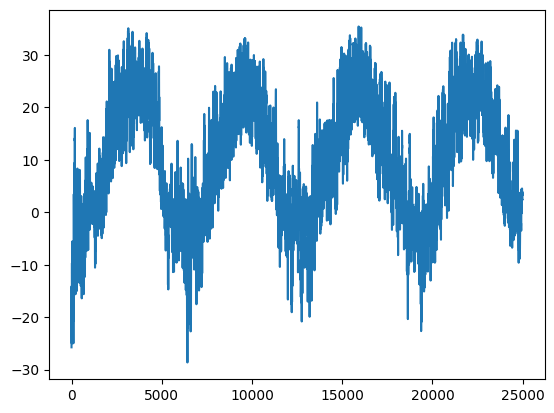

In [57]:
import matplotlib.pyplot as plt


plt.plot(the_df["t2m_nysm_1"])

Isolate one NYSM station and drop unnecessary columns 

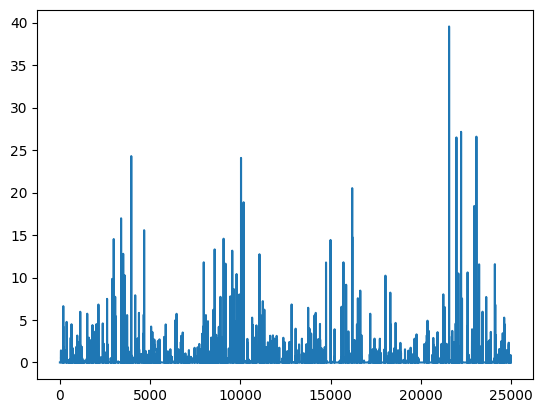

In [58]:
plt.plot(the_df["new_tp_nysm_1"])

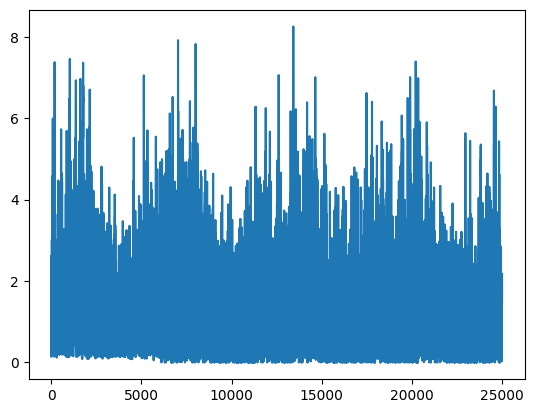

In [59]:
plt.plot(the_df["u_total_nysm_1"])

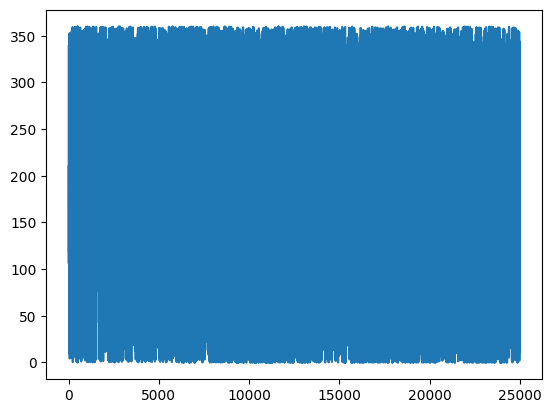

In [60]:
plt.plot(the_df["u_dir_nysm_1"])

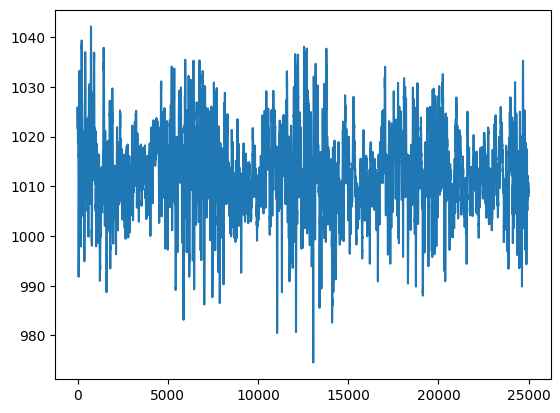

In [61]:
plt.plot(the_df["mslma_nysm_1"])

Create your target variable, and create a target variable column. The newly created target column won’t have values in the final 12 rows, so we’ll drop those

In [130]:
target_sensor = "mslma_nysm_1"
features = list(the_df.columns.difference([target_sensor]))

forecast_lead = 12
target = f"{target_sensor}_lead_{forecast_lead}"

the_df[target] = the_df[target_sensor].shift(-forecast_lead)
the_df = the_df.iloc[:-forecast_lead]

Create and hold out a test set

In [131]:
test_start = 19563

df_train = the_df.iloc[:19563].copy()
df_test = the_df.iloc[19563:].copy()

print("Test set fraction:", len(df_test) / len(the_df))

Test set fraction: 0.2147473206759523


Standardize your features and target

In [132]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

create a PyTorch Dataset class, which is simpler than you might think. This strategy lets us lean on PyTorch’s nice DataLoader class to keep the model training and evaluation code super clean.

Our custom Dataset just needs to specify what happens when somebody requests the i’th element of the dataset. In a tabular dataset, this would be the i’th row of the table, but here we need to retrieve a sequence of rows.

So, given i and the sequence_length, we return the block of data from i - sequence_length through row i. If i is at the beginning of the dataset, we pad by repeating the first row as many times as needed to make the output have sequence_length rows. The only trick is avoiding off-by-1 errors in the slicing and padding.

All the magic happens in the __getitem__ method in this snippet.

In [133]:
import torch
from torch.utils.data import Dataset


class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start : (i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0 : (i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [134]:
# Let’s look at a small example to build intuition about how it works. Namely, let’s grab the 27’th entry in the dataset with a sequence length of 4.

i = 27
sequence_length = 4

train_dataset = SequenceDataset(
    df_train, target=target, features=features, sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[-1.4647e+00, -1.3866e+00, -1.5281e+00, -1.4850e+00, -1.6954e+00,
         -1.7118e+00, -1.7424e+00, -1.6645e+00, -1.6142e-03, -5.4111e-04,
         -8.2540e-04,  3.3522e-04,  0.0000e+00,  8.1898e-04,  0.0000e+00,
          0.0000e+00,  8.2760e-01,  8.2097e-01,  8.6769e-01,  7.6259e-01,
          6.3377e-01,  1.0611e+00,  3.1663e-01,  6.7929e-01,  6.1282e-01,
         -1.1746e-01, -1.3493e-01, -1.4467e-01, -1.3941e-01, -1.6491e-01,
         -1.6458e-01, -1.6458e-01, -1.5277e-01, -1.5425e-01, -2.5923e-01,
         -2.5924e-01,  2.5924e-01, -2.5923e-01, -1.3361e+00, -1.3532e+00,
         -1.4066e+00, -1.3239e+00, -1.6614e+00, -1.6739e+00, -1.6398e+00,
         -1.7321e+00,  4.6177e-01,  7.0921e-03,  2.8835e-02,  3.8599e-01,
         -9.7408e-02, -2.0109e-01, -4.0709e-01,  2.3805e-02,  5.7931e-01,
          5.0354e-01,  7.2659e-01,  1.1437e+00,  2.5857e-01,  7.9711e-01,
         -3.4416e-01,  4.3367e-01],
        [-1.5216e+00, -1.5364e+00, -1.5489e+00, -1.5534e+00, -1.7284e+00,
  

The next step is to set the dataset in a PyTorch DataLoader, which will draw minibatches of data for us. Let’s try a small batch size of 3, to illustrate.

In [135]:
from torch.utils.data import DataLoader

torch.manual_seed(99)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 4, 62])
tensor([[[-5.9145e-01, -9.6923e-01, -8.1761e-01, -6.1336e-01, -8.7168e-01,
          -8.3239e-01, -9.1186e-01, -8.4816e-01, -1.6142e-03, -5.4111e-04,
          -8.2540e-04,  3.3522e-04,  0.0000e+00,  8.1898e-04,  0.0000e+00,
           0.0000e+00,  8.4946e-01,  8.7890e-01,  8.7862e-01,  8.6238e-01,
           9.1748e-01, -1.1304e-01,  1.3600e+00,  8.8794e-01,  9.5917e-01,
          -1.5127e-01, -1.4761e-01, -1.5874e-01, -1.5318e-01, -1.6491e-01,
          -1.6458e-01, -1.6458e-01, -1.5277e-01, -1.5425e-01,  3.8572e+00,
           3.8572e+00, -3.8572e+00,  3.8572e+00, -8.6388e-01, -1.1958e+00,
          -1.1082e+00, -8.4464e-01, -1.2457e+00, -1.2216e+00, -1.0207e+00,
          -1.2387e+00, -3.1780e-01, -4.9252e-01, -8.9782e-01, -6.1000e-02,
           1.5103e+00,  1.0900e+00, -6.5103e-01,  9.2743e-01,  3.1457e-01,
          -9.3610e-01, -2.4162e-01,  3.9216e-02, -7.3141e-01, -8.4237e-01,
          -3.3463e-01, -7.9762e-01],
         [-5.9429e-01, -9.8440e-01, -8.3

with a sequence of 48 time steps. For training, we’ll shuffle the data (the rows within each data sequence are not shuffled, only the order in which we draw the blocks). For the test set, shuffling isn’t necessary.

In [136]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 12

train_dataset = SequenceDataset(
    df_train, target=target, features=features, sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test, target=target, features=features, sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 12, 62])
Target shape: torch.Size([4])


Most importantly, we have to keep track of which dimension represents the batch in our input tensors. As we just saw, our data loaders use the first dimension for this, but the PyTorch LSTM layer’s default is to use the second dimension instead. So we set batch_first=True to make the dimensions line up, but confusingly, this doesn’t apply to the hidden and cell state tensors. In the forward method, we initialize h0 and c0 with batch size as the second dimension.

We’ll hard code a single layer just to keep things simple.

The output layer of the model is linear with a single output unit because we’re doing regression. This is one of only two lines of code that would need to change for a classification task.

In [137]:
from torch import nn


class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 4

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers,
        )
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(
            self.num_layers, batch_size, self.hidden_units
        ).requires_grad_()
        c0 = torch.zeros(
            self.num_layers, batch_size, self.hidden_units
        ).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(
            hn[0]
        ).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [138]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [139]:
learning_rate = 5e-5
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [140]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # loss
    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    # loss
    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")

    return avg_loss

In [141]:
batch_size = 100
sequence_length = 12
learning_rate = 0.001
num_hidden_units = 15

experiment = Experiment(
    api_key="leAiWyR5Ck7tkdiHIT7n6QWNa",
    project_name="general",
    workspace="shmaronshmevans",
)
torch.manual_seed(101)

batch_size = batch_size
sequence_length = sequence_length

train_dataset = SequenceDataset(
    df_train, target=target, features=features, sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test, target=target, features=features, sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

learning_rate = learning_rate
num_hidden_units = num_hidden_units

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
early_stopper = EarlyStopper(patience=5, min_delta=0)


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(50):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    val_loss = test_model(test_loader, model, loss_function)
    print()
    if early_stopper.early_stop(val_loss):
        break

# Report multiple hyperparameters using a dictionary:
hyper_params = {
    "learning_rate": learning_rate,
    "steps": sequence_length,
    "batch_size": batch_size,
}
experiment.log_parameters(hyper_params)

# Seamlessly log your Pytorch model
log_model(experiment, model, model_name="TheModel")
experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/shmaronshmevans/general/1eab8f08b565462584b82622cbb0f5d6



Features shape: torch.Size([100, 12, 62])
Target shape: torch.Size([100])
Untrained test
--------
Test loss: 0.9121426310804155

Epoch 0
---------
Train loss: 0.3553469021025361
Test loss: 0.1478726198827779

Epoch 1
---------
Train loss: 0.07162467230643545
Test loss: 0.07776120146391569

Epoch 2
---------
Train loss: 0.03234234867066297
Test loss: 0.045078549861769984

Epoch 3
---------
Train loss: 0.017721671620573923
Test loss: 0.030491850097422248

Epoch 4
---------
Train loss: 0.011197886384586443
Test loss: 0.021799615325613156

Epoch 5
---------
Train loss: 0.00766120453327134
Test loss: 0.016241121312810317

Epoch 6
---------
Train loss: 0.0055124840796545
Test loss: 0.011903142776443727

Epoch 7
---------
Train loss: 0.004141337718168388
Test loss: 0.009654611017106584

Epoch 8
---------
Train loss: 0.0032300413324858764
Test loss: 0.007470099522766692

Epoch 9
---------
Train loss: 0.002562216833490422
Test loss: 0.006581626168486697

Epoch 10
---------
Train loss: 0.0020895

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/shmaronshmevans/general/1eab8f08b565462584b82622cbb0f5d6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [980] : (5.802297164336778e-05, 1.2854533195495605)
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 100
COMET INFO:     learning_rate : 0.001
COMET INFO:     steps         : 12
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO: 

## Evalutation

Evaluating the model is straightforward. First, let’s define a variant of the test function that actually returns the predictions. We also need a new DataLoader for the training set that isn’t shuffled, we can visualize the training and test set predictions chronologically. Lastly, it’s nice to un-standardize the predictions so they’re back in their original units.

In [142]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

       mslma_nysm_1_lead_12  Model forecast
0               1022.192017     1022.274231
1               1021.806030     1021.795898
2               1021.723022     1021.655823
3               1021.705994     1021.726379
4               1021.474976     1021.444702
...                     ...             ...
24908           1005.422974     1005.545105
24909           1005.890991     1006.119812
24910           1006.135986     1006.316467
24911           1005.721985     1005.866028
24912           1005.669006     1005.792480

[24913 rows x 2 columns]


In [143]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"
plot_template = dict(
    layout=go.Layout(
        {"font_size": 18, "xaxis_title_font_size": 24, "yaxis_title_font_size": 24}
    )
)

fig = px.line(df_out, labels=dict(created_at="Date", value="T2M [Celsius]"))
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.add_annotation(
    xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False
)
fig.update_layout(
    template=plot_template, legend=dict(orientation="h", y=1.02, title_text="")
)
fig.show()